# Godwin's Law on Reddit

Author: [@edridgedsouza](https://github.com/edridgedsouza/GODWIN)

Second Jupyter notebook for playing with the database while the other one is busy scraping.

**DISCLAIMER**: The selection of subreddits is clearly not random. By necessity, it includes
the most popular subreddits and subreddits that include the most-commented threads, as well
as some individually added political (or political-adjacent) subs. This alone tells you that
the sample space is not truly random; however, this is partly necessary as the only way to 
sample threads with high comment counts is often to take the most popular subs.


To account for the bias provided by adding in political subs, part of this analysis
will also attempt to calculate separate statistics for subs that aren't political or
political-adjacent. However, this is clearly very subjective as even nominally 
"apolitical" content can very much be political. Anyone who wishes to categorize the subs
differently can download the database and try their own custom visualization.

Terminology: a "failure event" in a thread is any reference to any of the "failure words" in
[Scraper.py](https://github.com/edridgedsouza/GODWIN/blob/master/godwin/Scraper.py#L42).

In [1]:
from godwin import Database, Scraper
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
import warnings
warnings.filterwarnings('ignore')

db = Database('Godwin.db')
posts = db.get_data()
posts['num_prev_comments'] += 1  # Off-by-one correction
posts['num_prev_comments'].fillna(posts['num_comments'], inplace=True)
posts['failure'] = posts['comment_id'].notnull().astype('int')


qry = '''
        SELECT 
            subreddit, 
            count(comment_id) AS n_failing,
            count(post_id) AS n_total,
            round(100.0*count(comment_id)/count(post_id), 2)
                AS percent_failing,
            round(avg(num_comments), 2) 
                AS avg_comments,
            round(avg(num_prev_comments), 2) 
                AS avg_failure_comments
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing DESC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
summary['percent_failing'] = summary['percent_failing'].astype(str) + '%'

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'{summary.shape[0]} subs, {posts.shape[0]} total posts')
    display(summary)
    

199 subs, 22973 total posts


,subreddit,n_failing,n_total,percent_failing,avg_comments,avg_failure_comments
0,ENLIGHTENEDCENTRISM,150,186,80.65%,818.81,42.24
1,politics,76,101,75.25%,3627.65,1081.04
2,AgainstHateSubreddits,120,171,70.18%,518.50,72.12
3,AskTrumpSupporters,103,147,70.07%,1361.68,432.27
4,Conservative,139,199,69.85%,2598.01,556.03
5,conspiracy,142,204,69.61%,1451.78,392.51
6,BreadTube,122,178,68.54%,439.62,65.93
7,COMPLETEANARCHY,129,190,67.89%,237.06,61.08
8,insanepeoplefacebook,133,202,65.84%,1926.67,395.37
9,ABoringDystopia,125,193,64.77%,1149.91,306.09


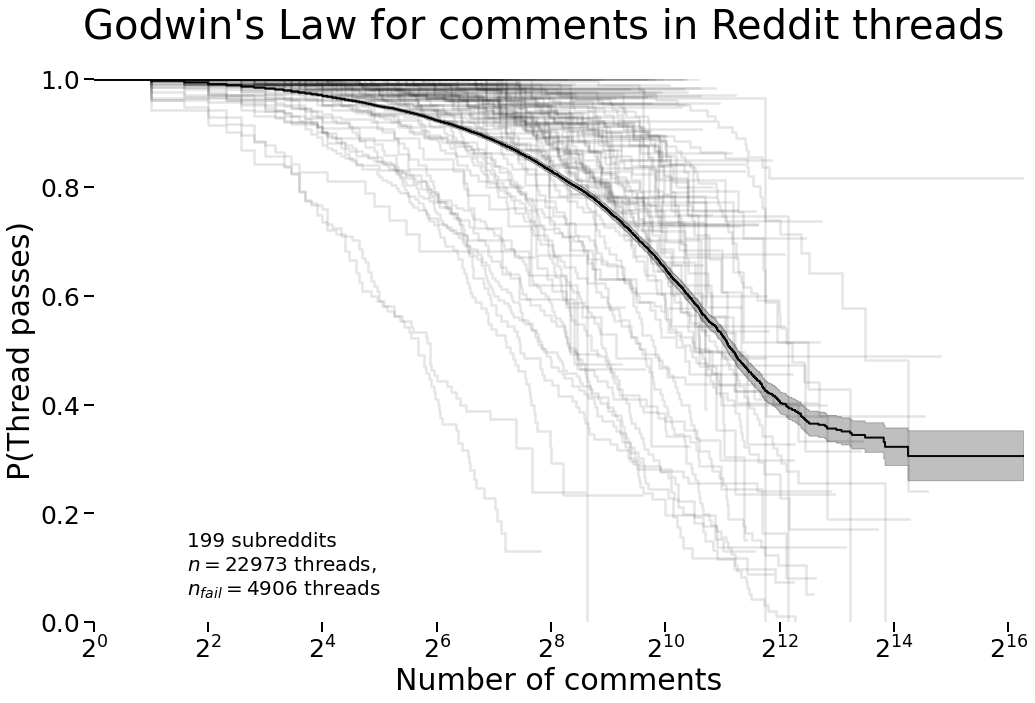

In [2]:
(fig, ax) = plt.subplots(1,1, figsize=(25 * 2/3, 15 * 2/3))

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

for sub in subs:
    subset = posts[posts.subreddit == sub]
    if subset.shape[0] != 0:
        kmf = KaplanMeierFitter()
        kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        kmf.plot(alpha=0.1, color='black', lw=2.5,
                 ci_show=False, ax=ax)
    
# Average model of all data
kmf = KaplanMeierFitter()
kmf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
kmf.plot(color='black', alpha=0.95, lw=2, ax=ax)
####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads", fontsize=40)
ax.set_xlabel('Number of comments', fontsize=30)
ax.set_ylabel('P(Thread passes)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.margins(x=0., y=0.)
fig.tight_layout()
ax.get_legend().remove()

samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.1, 0.05, samplesize, transform=ax.transAxes, fontsize=20)

plt.box(on=None)

ax.set_xscale('log', base=2)
# ax.set_xlim(0, 15000)

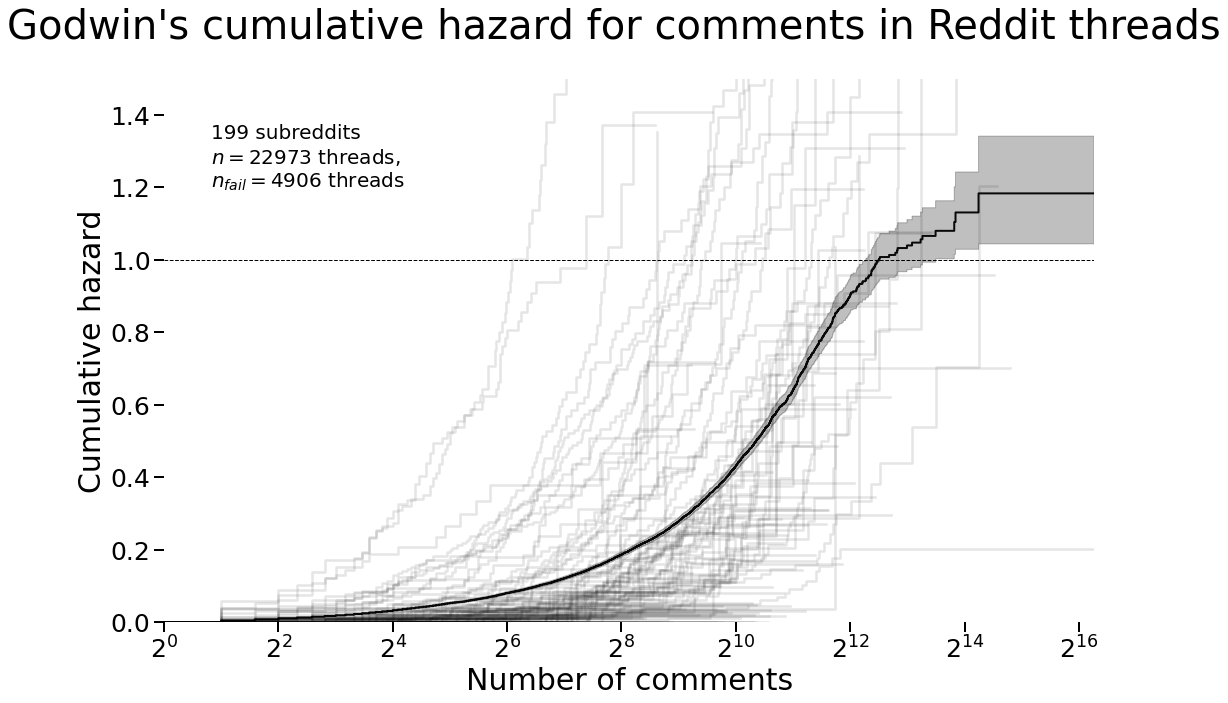

In [3]:
(fig, ax) = plt.subplots(1,1, figsize=(25 * 2/3, 15 * 2/3))

for sub in subs:
    subset = posts[posts.subreddit == sub]
    if subset.shape[0] != 0:
        naf = NelsonAalenFitter()
        naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        naf.plot(alpha=0.1, color='black', lw=2.5,
                 ci_show=False, ax=ax)

naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot_cumulative_hazard(color='black', alpha=0.95, lw=2, ax=ax)

ax.axhline(y=1.0, xmin=0, xmax=posts.num_prev_comments.max(), ls='--', lw=1, color='black')
####################################################################################


fig.suptitle(f"Godwin's cumulative hazard for comments in Reddit threads", fontsize=40)
ax.set_xlabel('Number of comments', fontsize=30)
ax.set_ylabel('Cumulative hazard', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.margins(x=0., y=0.)
fig.tight_layout()
ax.get_legend().remove()

samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.05, 0.8, samplesize, transform=ax.transAxes, fontsize=20)

ax.set_xscale('log', base=2)
ax.set_ylim(0, 1.5)

plt.box(on=None)

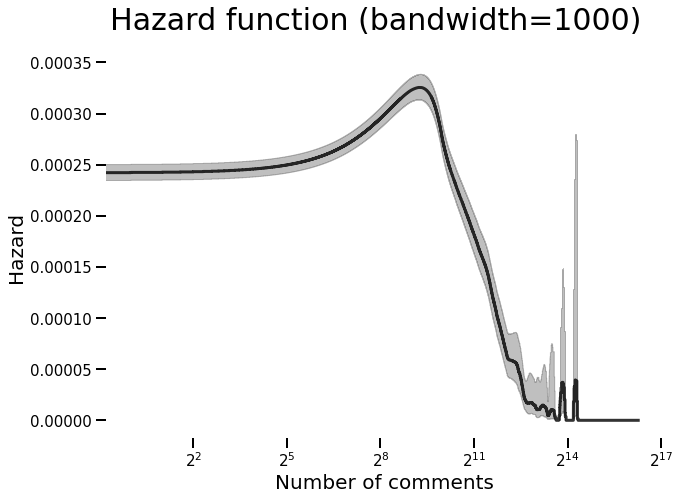

In [4]:
(fig, ax) = plt.subplots(1,1, figsize=(10,7))
naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot_hazard(color='black', alpha=0.8, ax=ax, lw=3, bandwidth=1000)
ax.set_xscale('log', base=2)

fig.suptitle('Hazard function (bandwidth=1000)', fontsize=30)
ax.set_xlabel('Number of comments', fontsize=20)
ax.set_ylabel('Hazard', fontsize=20)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.get_legend().remove()
plt.box(on=None)

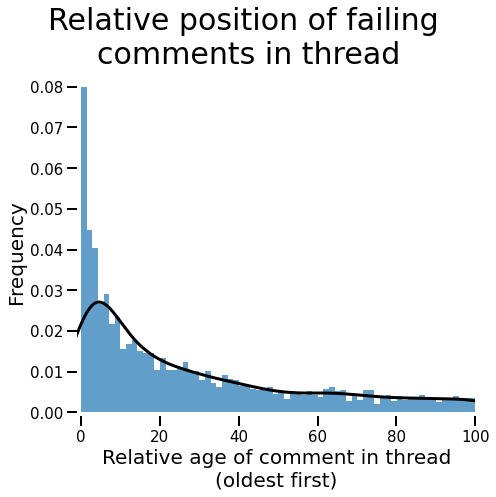

In [5]:
hits = posts[posts.failure == 1]

hits['percentile'] = (5*100*hits.num_prev_comments/hits.num_comments).round()/5

(fig, ax) = plt.subplots(1,1, figsize=(7,7))
hits['percentile'].plot.hist(density=True, bins=100, alpha=0.7, ax=ax)
hits['percentile'].plot.kde(legend=False, color='black', lw=3, ax=ax)

ax.set_xlabel('Relative age of comment in thread\n(oldest first)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
fig.suptitle('Relative position of failing \ncomments in thread', fontsize=30)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.set_xlim(-1, 100)
ax.set_ylim(-0.001, 0.08)
fig.tight_layout()
plt.box(on=None)

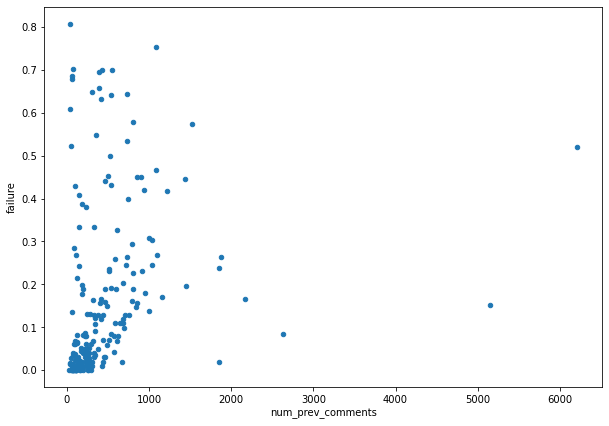

In [6]:
(fig, ax) = plt.subplots(1,1, figsize=(10,7))

ax = posts.groupby(['subreddit']).mean().plot.scatter('num_prev_comments', 'failure', ax=ax)
#ax.set_xscale('log', base=10)